In [1]:
import eland as ed
import numpy as np
import matplotlib.pyplot as plt
import os

from elasticsearch import Elasticsearch
from dotenv import load_dotenv

os.chdir("..")
load_dotenv()

True

In [2]:
es_url = os.environ.get('ELASTICSEARCH_URL')
es_api_key = os.environ.get('ELASTICSEARCH_API_KEY')
es = Elasticsearch(hosts=[f"{es_url}"], api_key=es_api_key)

In [3]:
%%capture
ticker="ASML"
df_eod = ed.DataFrame(es, es_index_pattern="quant-agents_stocks-eod_*")
df_eod = df_eod[(df_eod.key_ticker == ticker)]
df_macd = ed.eland_to_pandas(df_eod).sort_values(by='date_reference', ascending=True).tail(100).set_index('date_reference')

In [4]:
# Reference: https://www.fmlabs.com/reference/default.htm?url=MACD.htm
short_period = 7
long_period = 20
signal_period = 6

# Calculate Short EMA (12-period)
df_macd['short_ema'] = df_macd['val_close'].ewm(span=short_period, adjust=False).mean()

# Calculate Long EMA (26-period)
df_macd['long_ema'] = df_macd['val_close'].ewm(span=long_period, adjust=False).mean()

# Calculate MACD Line
df_macd['macd'] = df_macd['short_ema'] - df_macd['long_ema']

# Calculate Signal Line (9-period EMA of MACD)
df_macd['signal'] = df_macd['macd'].ewm(span=signal_period, adjust=False).mean()

# Calculate Histogram
df_macd['histogram'] = df_macd['macd'] - df_macd['signal']

# Drop NaN rows (due to ewm)
df_macd.dropna(inplace=True)

In [5]:
df_macd.tail()

,key_ticker,val_close,val_high,val_low,val_open,val_volume,short_ema,long_ema,macd,signal,histogram
date_reference,,,,,,,,,,,
2025-10-17,ASML,1029.270,1032.765,1015.00,1020.590,1663654,1004.769253,971.714681,33.054572,34.340301,-1.285729
2025-10-20,ASML,1042.150,1052.170,1031.49,1031.750,1271713,1014.114440,978.422807,35.691633,34.726396,0.965237
2025-10-21,ASML,1025.020,1037.475,1024.15,1036.305,1072158,1016.840830,982.860635,33.980195,34.513196,-0.533000
2025-10-22,ASML,1011.565,1033.180,997.67,1026.450,1328598,1015.521872,985.594384,29.927489,33.202994,-3.275505
2025-10-23,ASML,1036.410,1040.500,1004.50,1004.520,1318221,1020.743904,990.433966,30.309938,32.376406,-2.066468


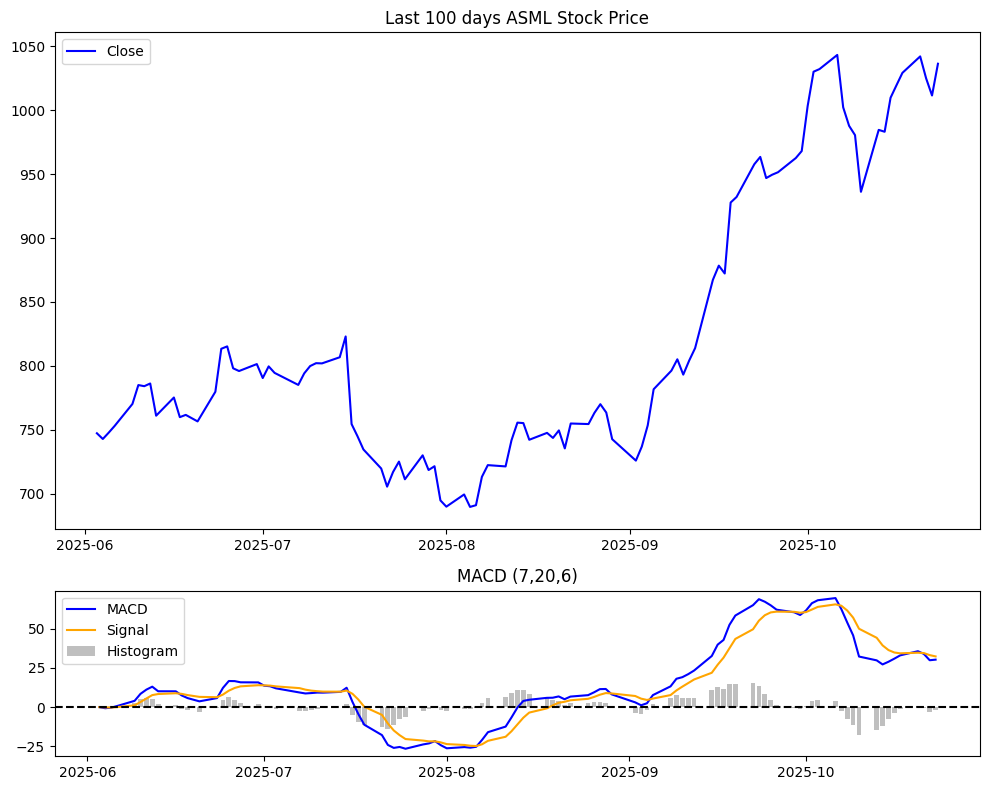

In [6]:
fig, axs = plt.subplots(2, 1, figsize=(10, 8), gridspec_kw={'height_ratios': [3, 1]})

# Top: Price plot
axs[0].plot(df_macd.index, df_macd['val_close'], label='Close', color='blue')
axs[0].set_title(f"Last 100 days {ticker} Stock Price")
axs[0].legend()

# Bottom: MACD plot
axs[1].plot(df_macd.index, df_macd['macd'], label='MACD', color='blue')
axs[1].plot(df_macd.index, df_macd['signal'], label='Signal', color='orange')
axs[1].bar(df_macd.index, df_macd['histogram'], label='Histogram', color='gray', alpha=0.5)
axs[1].axhline(0, color='black', linestyle='--')
axs[1].set_title(f"MACD ({short_period},{long_period},{signal_period})")
axs[1].legend()

plt.tight_layout()
plt.show()

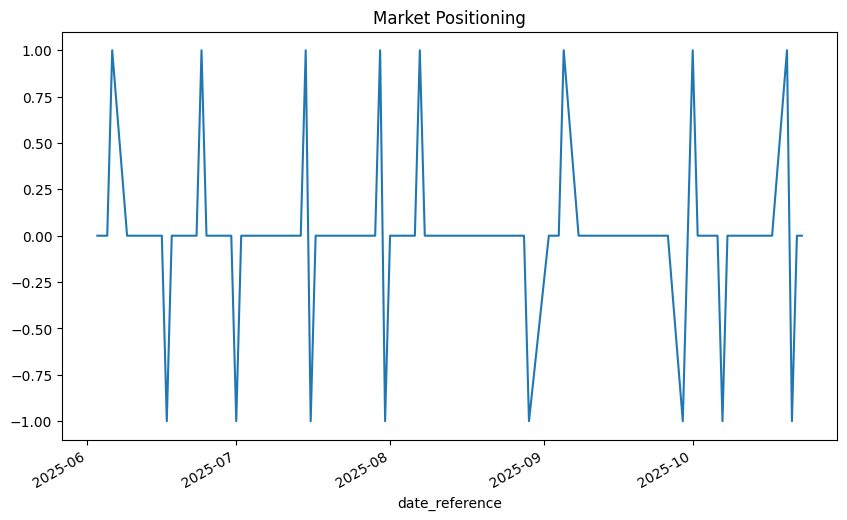

In [7]:
df_macd['prev_macd'] = df_macd['macd'].shift(1)
df_macd['prev_signal'] = df_macd['signal'].shift(1)
df_macd['position'] = np.where((df_macd['prev_macd'] < df_macd['prev_signal']) & (df_macd['macd'] > df_macd['signal']), 1,np.where((df_macd['prev_macd'] > df_macd['prev_signal']) & (df_macd['macd'] < df_macd['signal']), -1, 0))
df_macd['position'].plot(
    ylim=[-1.1, 1.1],
    title='Market Positioning',
    figsize=(10, 6)
);

In [8]:
df_macd['returns'] = np.log(df_macd['val_close'] / df_macd['val_close'].shift(1))
df_macd['strategy'] = df_macd['position'].shift(1) * df_macd['returns']
df_macd[['returns', 'strategy']].sum().apply(np.exp)

returns     1.386966
strategy    0.992202
dtype: float64

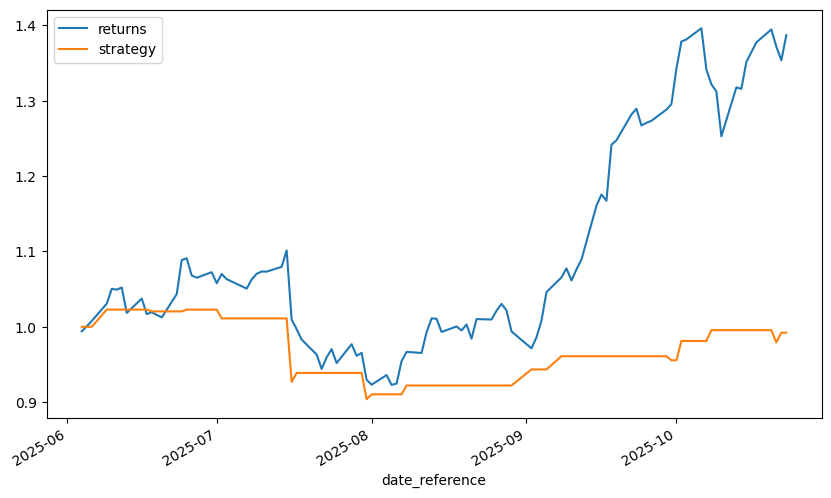

In [9]:
df_macd[['returns', 'strategy']].dropna().cumsum().apply(np.exp).plot(figsize=(10, 6));

In [10]:
# Detect crossovers and extremes (MACD >0 bullish, <0 bearish; divergences)
df_macd['divergence_bearish'] = (df_macd['val_close'].diff() > 0) & (df_macd['macd'].diff() < 0)  # Price up, MACD down
df_macd['divergence_bullish'] = (df_macd['val_close'].diff() < 0) & (df_macd['macd'].diff() > 0)  # Price down, MACD up
crossovers = df_macd[df_macd['position'] != 0]
print(crossovers[['val_close', 'macd', 'signal', 'histogram', 'position']])

                val_close       macd     signal  histogram  position
date_reference                                                      
2025-06-06         753.02   0.664549   0.012696   0.651853         1
2025-06-17         759.86   7.454265   8.457585  -1.003320        -1
2025-06-24         813.36  12.266772   8.022938   4.243833         1
2025-07-01         790.47  13.671899  13.894526  -0.222628        -1
2025-07-15         823.02  12.369815  10.576866   1.792949         1
2025-07-16         754.45   3.246014   8.482337  -5.236322        -1
2025-07-30         721.45 -21.688502 -21.818893   0.130391         1
2025-07-31         694.71 -24.320767 -22.533714  -1.787053        -1
2025-08-07         713.12 -20.906795 -23.717165   2.810370         1
2025-08-29         742.62   8.150461   8.728155  -0.577694        -1
2025-09-05         781.70   7.663923   5.454841   2.209083         1
2025-09-29         962.61  60.538705  60.836720  -0.298015        -1
2025-10-01        1003.27  61.6925